# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|████████████████| 60.0K/60.0K [00:26<00:00, 2.24KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

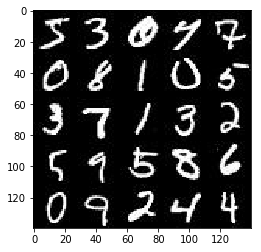

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

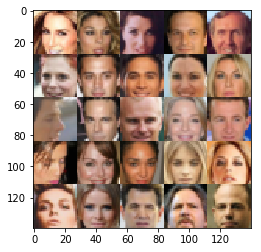

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


D:\Anaconda2\envs\tflearn\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    
    return real_input, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    
    with tf.variable_scope("discriminator", reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2,  training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3,  training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)

        flat  = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
   
    alpha = 0.1
    
    with tf.variable_scope("generator", reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 7x7x512
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding="same")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x256
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding="same")
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
     
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.9786... Generator Loss: 0.7593
Epoch 0/2... Discriminator Loss: 1.4494... Generator Loss: 4.4142
Epoch 0/2... Discriminator Loss: 0.8860... Generator Loss: 0.7853
Epoch 0/2... Discriminator Loss: 0.3638... Generator Loss: 2.1887


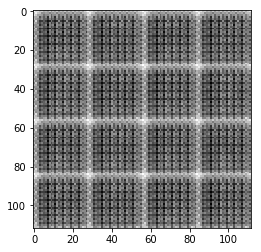

Epoch 0/2... Discriminator Loss: 0.2483... Generator Loss: 2.0059
Epoch 0/2... Discriminator Loss: 0.6848... Generator Loss: 0.9261
Epoch 0/2... Discriminator Loss: 2.1022... Generator Loss: 0.2141
Epoch 0/2... Discriminator Loss: 0.8756... Generator Loss: 1.1887
Epoch 0/2... Discriminator Loss: 1.8398... Generator Loss: 0.4473


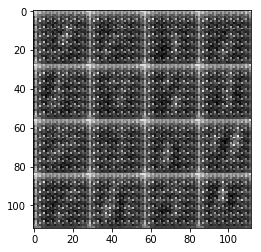

Epoch 0/2... Discriminator Loss: 1.0407... Generator Loss: 1.1084
Epoch 0/2... Discriminator Loss: 2.2838... Generator Loss: 0.1573
Epoch 0/2... Discriminator Loss: 1.2379... Generator Loss: 1.0993
Epoch 0/2... Discriminator Loss: 1.0788... Generator Loss: 0.9903
Epoch 0/2... Discriminator Loss: 1.7146... Generator Loss: 0.3230


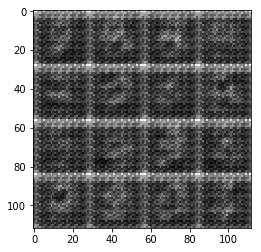

Epoch 0/2... Discriminator Loss: 1.0600... Generator Loss: 0.7867
Epoch 0/2... Discriminator Loss: 1.0258... Generator Loss: 0.7184
Epoch 0/2... Discriminator Loss: 1.5038... Generator Loss: 0.4537
Epoch 0/2... Discriminator Loss: 1.5130... Generator Loss: 0.3316
Epoch 0/2... Discriminator Loss: 0.9122... Generator Loss: 0.8638


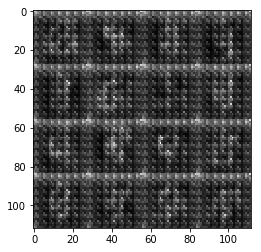

Epoch 0/2... Discriminator Loss: 0.9884... Generator Loss: 1.1933
Epoch 0/2... Discriminator Loss: 1.0849... Generator Loss: 1.2631
Epoch 0/2... Discriminator Loss: 0.7238... Generator Loss: 1.3919
Epoch 0/2... Discriminator Loss: 0.8819... Generator Loss: 1.2017
Epoch 0/2... Discriminator Loss: 0.9638... Generator Loss: 0.8093


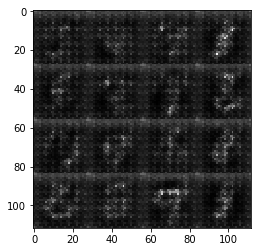

Epoch 0/2... Discriminator Loss: 0.9046... Generator Loss: 0.7477
Epoch 0/2... Discriminator Loss: 0.7951... Generator Loss: 1.2772
Epoch 0/2... Discriminator Loss: 0.8646... Generator Loss: 1.3542
Epoch 0/2... Discriminator Loss: 1.1811... Generator Loss: 0.5796
Epoch 0/2... Discriminator Loss: 0.9691... Generator Loss: 0.7830


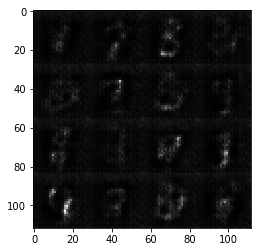

Epoch 0/2... Discriminator Loss: 0.7666... Generator Loss: 0.9818
Epoch 0/2... Discriminator Loss: 0.9763... Generator Loss: 0.6986
Epoch 0/2... Discriminator Loss: 0.7522... Generator Loss: 1.2158
Epoch 0/2... Discriminator Loss: 0.9505... Generator Loss: 1.3486
Epoch 0/2... Discriminator Loss: 1.0291... Generator Loss: 0.6616


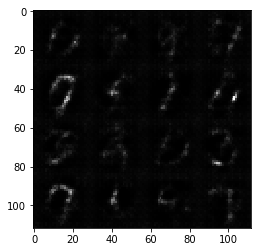

Epoch 0/2... Discriminator Loss: 0.8581... Generator Loss: 1.6202
Epoch 0/2... Discriminator Loss: 0.9579... Generator Loss: 1.3361
Epoch 0/2... Discriminator Loss: 1.3641... Generator Loss: 0.3704
Epoch 0/2... Discriminator Loss: 1.0709... Generator Loss: 0.6234
Epoch 0/2... Discriminator Loss: 0.7819... Generator Loss: 0.8535


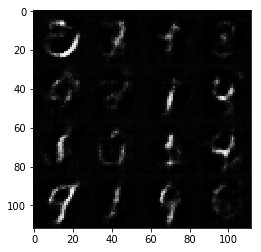

Epoch 0/2... Discriminator Loss: 1.0121... Generator Loss: 0.7478
Epoch 0/2... Discriminator Loss: 1.7400... Generator Loss: 0.2778
Epoch 0/2... Discriminator Loss: 1.0185... Generator Loss: 0.8106
Epoch 0/2... Discriminator Loss: 1.2032... Generator Loss: 1.3169
Epoch 0/2... Discriminator Loss: 0.9242... Generator Loss: 1.0444


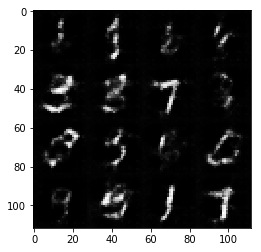

Epoch 0/2... Discriminator Loss: 0.8875... Generator Loss: 0.7868
Epoch 0/2... Discriminator Loss: 0.9765... Generator Loss: 1.0572
Epoch 0/2... Discriminator Loss: 1.0811... Generator Loss: 0.5695
Epoch 0/2... Discriminator Loss: 1.0430... Generator Loss: 0.8708
Epoch 0/2... Discriminator Loss: 1.1192... Generator Loss: 0.7018


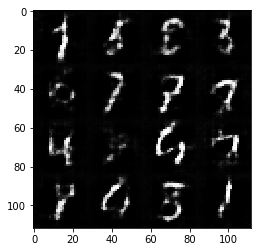

Epoch 0/2... Discriminator Loss: 1.2970... Generator Loss: 0.4112
Epoch 0/2... Discriminator Loss: 1.0516... Generator Loss: 1.2468
Epoch 0/2... Discriminator Loss: 1.0104... Generator Loss: 0.5996
Epoch 0/2... Discriminator Loss: 0.8020... Generator Loss: 2.0723
Epoch 0/2... Discriminator Loss: 1.1504... Generator Loss: 0.5169


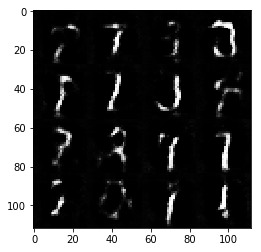

Epoch 0/2... Discriminator Loss: 0.9204... Generator Loss: 1.1836
Epoch 0/2... Discriminator Loss: 1.1369... Generator Loss: 1.6701
Epoch 0/2... Discriminator Loss: 1.0237... Generator Loss: 0.7352
Epoch 0/2... Discriminator Loss: 1.0722... Generator Loss: 1.2673
Epoch 0/2... Discriminator Loss: 0.8224... Generator Loss: 1.1266


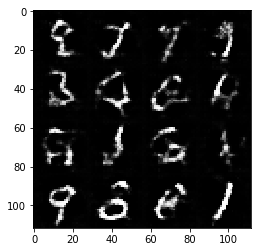

Epoch 0/2... Discriminator Loss: 1.0748... Generator Loss: 0.7202
Epoch 0/2... Discriminator Loss: 0.9695... Generator Loss: 0.9578
Epoch 0/2... Discriminator Loss: 1.4068... Generator Loss: 0.3478
Epoch 0/2... Discriminator Loss: 0.9014... Generator Loss: 0.9304
Epoch 0/2... Discriminator Loss: 0.9844... Generator Loss: 1.3118


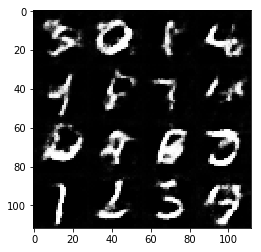

Epoch 0/2... Discriminator Loss: 1.1630... Generator Loss: 0.5634
Epoch 0/2... Discriminator Loss: 1.0749... Generator Loss: 0.6749
Epoch 0/2... Discriminator Loss: 1.2110... Generator Loss: 1.5156
Epoch 0/2... Discriminator Loss: 0.9908... Generator Loss: 0.6412
Epoch 0/2... Discriminator Loss: 1.4110... Generator Loss: 0.3780


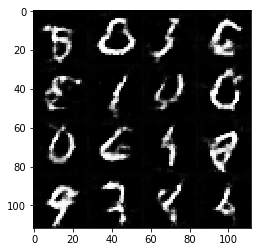

Epoch 0/2... Discriminator Loss: 0.8627... Generator Loss: 0.8271
Epoch 0/2... Discriminator Loss: 1.2738... Generator Loss: 0.4438
Epoch 0/2... Discriminator Loss: 0.8975... Generator Loss: 0.9347
Epoch 0/2... Discriminator Loss: 0.9560... Generator Loss: 1.6392
Epoch 0/2... Discriminator Loss: 0.9167... Generator Loss: 0.8115


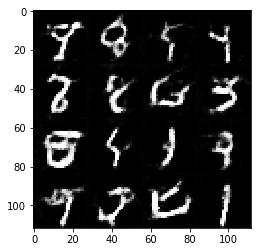

Epoch 0/2... Discriminator Loss: 1.0323... Generator Loss: 0.9431
Epoch 0/2... Discriminator Loss: 0.7119... Generator Loss: 1.6119
Epoch 0/2... Discriminator Loss: 1.0520... Generator Loss: 0.6622
Epoch 0/2... Discriminator Loss: 1.1076... Generator Loss: 0.7691
Epoch 0/2... Discriminator Loss: 1.1956... Generator Loss: 0.6772


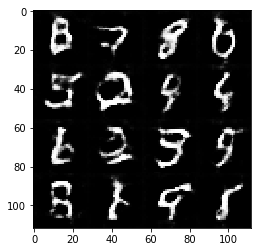

Epoch 0/2... Discriminator Loss: 1.4799... Generator Loss: 0.3867
Epoch 0/2... Discriminator Loss: 0.7099... Generator Loss: 1.2576
Epoch 0/2... Discriminator Loss: 1.1337... Generator Loss: 0.5251
Epoch 0/2... Discriminator Loss: 0.9032... Generator Loss: 0.9622
Epoch 0/2... Discriminator Loss: 0.6771... Generator Loss: 1.5637


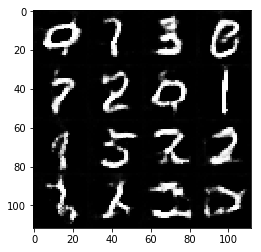

Epoch 0/2... Discriminator Loss: 0.8044... Generator Loss: 0.9959
Epoch 0/2... Discriminator Loss: 0.9687... Generator Loss: 1.0085
Epoch 0/2... Discriminator Loss: 1.6153... Generator Loss: 0.3496
Epoch 0/2... Discriminator Loss: 1.2622... Generator Loss: 0.5076
Epoch 0/2... Discriminator Loss: 1.4579... Generator Loss: 0.3741


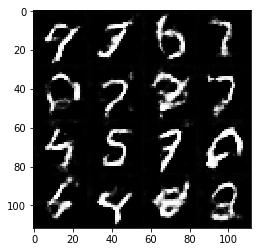

Epoch 0/2... Discriminator Loss: 0.8960... Generator Loss: 0.8883
Epoch 0/2... Discriminator Loss: 0.7503... Generator Loss: 1.5102
Epoch 0/2... Discriminator Loss: 1.0126... Generator Loss: 0.6888
Epoch 0/2... Discriminator Loss: 1.0527... Generator Loss: 1.5348
Epoch 0/2... Discriminator Loss: 1.2737... Generator Loss: 0.4941


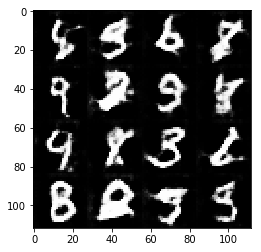

Epoch 0/2... Discriminator Loss: 0.8639... Generator Loss: 0.9342
Epoch 0/2... Discriminator Loss: 0.7150... Generator Loss: 1.0921
Epoch 0/2... Discriminator Loss: 0.9119... Generator Loss: 0.9625
Epoch 0/2... Discriminator Loss: 0.7135... Generator Loss: 1.6032
Epoch 0/2... Discriminator Loss: 1.4366... Generator Loss: 0.3340


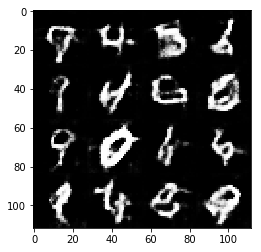

Epoch 0/2... Discriminator Loss: 1.1775... Generator Loss: 0.5269
Epoch 0/2... Discriminator Loss: 1.1022... Generator Loss: 0.6693
Epoch 0/2... Discriminator Loss: 1.0662... Generator Loss: 0.6863
Epoch 0/2... Discriminator Loss: 1.6060... Generator Loss: 0.2834
Epoch 0/2... Discriminator Loss: 0.8956... Generator Loss: 1.7000


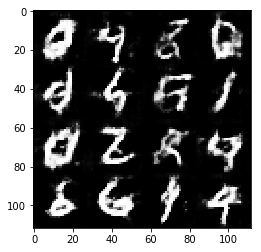

Epoch 0/2... Discriminator Loss: 0.7112... Generator Loss: 1.0816
Epoch 0/2... Discriminator Loss: 0.8605... Generator Loss: 1.3732
Epoch 0/2... Discriminator Loss: 1.0560... Generator Loss: 0.6032
Epoch 0/2... Discriminator Loss: 1.3551... Generator Loss: 0.4510
Epoch 0/2... Discriminator Loss: 1.1338... Generator Loss: 0.5510


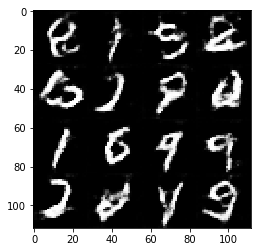

Epoch 0/2... Discriminator Loss: 1.4547... Generator Loss: 0.4475
Epoch 0/2... Discriminator Loss: 2.8515... Generator Loss: 0.0946
Epoch 0/2... Discriminator Loss: 0.8320... Generator Loss: 1.0468
Epoch 0/2... Discriminator Loss: 0.7484... Generator Loss: 1.3730
Epoch 0/2... Discriminator Loss: 1.2576... Generator Loss: 0.4437


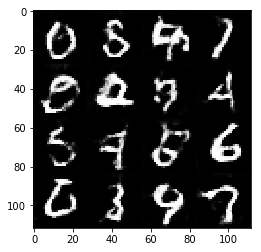

Epoch 0/2... Discriminator Loss: 0.8070... Generator Loss: 0.8117
Epoch 0/2... Discriminator Loss: 0.9161... Generator Loss: 0.7352
Epoch 0/2... Discriminator Loss: 0.9923... Generator Loss: 0.6330
Epoch 0/2... Discriminator Loss: 1.3403... Generator Loss: 0.4196
Epoch 0/2... Discriminator Loss: 0.7522... Generator Loss: 0.9197


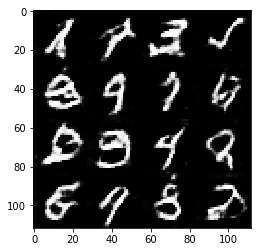

Epoch 0/2... Discriminator Loss: 0.9277... Generator Loss: 0.7389
Epoch 0/2... Discriminator Loss: 0.5624... Generator Loss: 1.5776
Epoch 0/2... Discriminator Loss: 0.9615... Generator Loss: 0.7536
Epoch 0/2... Discriminator Loss: 1.1923... Generator Loss: 0.5724
Epoch 0/2... Discriminator Loss: 0.5794... Generator Loss: 1.2704


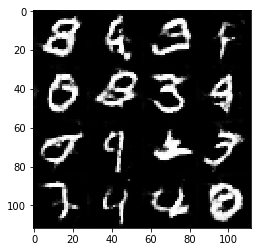

Epoch 0/2... Discriminator Loss: 0.6145... Generator Loss: 1.5819
Epoch 0/2... Discriminator Loss: 0.8718... Generator Loss: 0.7542
Epoch 0/2... Discriminator Loss: 0.5810... Generator Loss: 1.4212
Epoch 0/2... Discriminator Loss: 0.5957... Generator Loss: 1.2805
Epoch 0/2... Discriminator Loss: 1.4495... Generator Loss: 0.3623


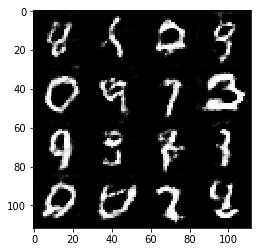

Epoch 0/2... Discriminator Loss: 1.4278... Generator Loss: 0.3597
Epoch 0/2... Discriminator Loss: 0.6691... Generator Loss: 0.9789
Epoch 0/2... Discriminator Loss: 0.9694... Generator Loss: 0.7170
Epoch 0/2... Discriminator Loss: 1.2101... Generator Loss: 0.4845
Epoch 0/2... Discriminator Loss: 0.9862... Generator Loss: 0.6738


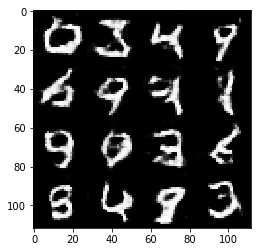

Epoch 0/2... Discriminator Loss: 1.0803... Generator Loss: 0.6423
Epoch 0/2... Discriminator Loss: 1.2773... Generator Loss: 0.4727
Epoch 0/2... Discriminator Loss: 1.0502... Generator Loss: 0.6293
Epoch 0/2... Discriminator Loss: 0.5680... Generator Loss: 1.4198
Epoch 0/2... Discriminator Loss: 0.5842... Generator Loss: 1.4365


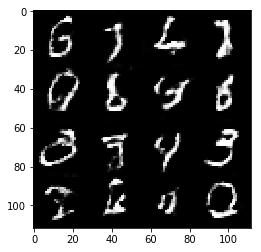

Epoch 0/2... Discriminator Loss: 1.5936... Generator Loss: 0.3454
Epoch 0/2... Discriminator Loss: 0.7319... Generator Loss: 1.0884
Epoch 0/2... Discriminator Loss: 0.7710... Generator Loss: 1.0664
Epoch 0/2... Discriminator Loss: 1.5169... Generator Loss: 0.3775
Epoch 0/2... Discriminator Loss: 0.7882... Generator Loss: 1.0713


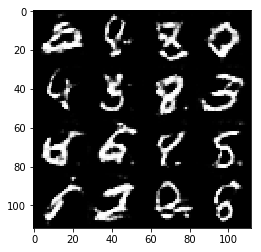

Epoch 0/2... Discriminator Loss: 0.7126... Generator Loss: 1.0619
Epoch 0/2... Discriminator Loss: 0.7625... Generator Loss: 0.9011
Epoch 0/2... Discriminator Loss: 1.2255... Generator Loss: 0.4486
Epoch 0/2... Discriminator Loss: 1.1488... Generator Loss: 0.5470
Epoch 0/2... Discriminator Loss: 1.5268... Generator Loss: 2.5160


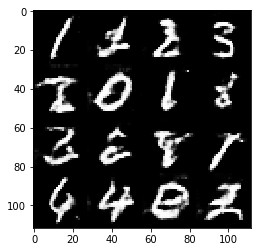

Epoch 0/2... Discriminator Loss: 0.5307... Generator Loss: 1.7706
Epoch 0/2... Discriminator Loss: 1.7268... Generator Loss: 0.2728
Epoch 0/2... Discriminator Loss: 0.7522... Generator Loss: 0.9450
Epoch 0/2... Discriminator Loss: 0.8201... Generator Loss: 0.9157
Epoch 0/2... Discriminator Loss: 0.5427... Generator Loss: 1.3291


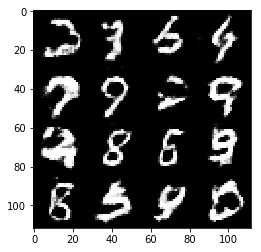

Epoch 0/2... Discriminator Loss: 0.5697... Generator Loss: 1.5758
Epoch 0/2... Discriminator Loss: 1.0681... Generator Loss: 0.6221
Epoch 0/2... Discriminator Loss: 0.7413... Generator Loss: 1.0380
Epoch 0/2... Discriminator Loss: 0.8584... Generator Loss: 0.9200
Epoch 0/2... Discriminator Loss: 0.4753... Generator Loss: 1.6383


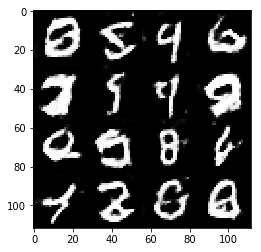

Epoch 0/2... Discriminator Loss: 1.1735... Generator Loss: 0.5796
Epoch 0/2... Discriminator Loss: 1.1157... Generator Loss: 0.6110
Epoch 0/2... Discriminator Loss: 1.5141... Generator Loss: 0.3333
Epoch 0/2... Discriminator Loss: 0.8504... Generator Loss: 0.8646
Epoch 0/2... Discriminator Loss: 0.7284... Generator Loss: 1.2109


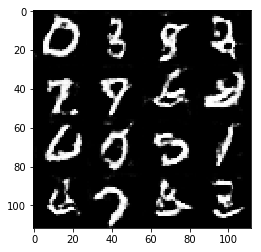

Epoch 0/2... Discriminator Loss: 0.4893... Generator Loss: 1.5899
Epoch 0/2... Discriminator Loss: 0.5233... Generator Loss: 1.3821
Epoch 0/2... Discriminator Loss: 1.7085... Generator Loss: 0.2758
Epoch 0/2... Discriminator Loss: 0.4855... Generator Loss: 1.4979
Epoch 0/2... Discriminator Loss: 1.0111... Generator Loss: 1.7827


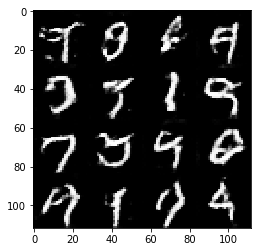

Epoch 0/2... Discriminator Loss: 0.9764... Generator Loss: 0.6656
Epoch 0/2... Discriminator Loss: 0.4377... Generator Loss: 1.5648
Epoch 0/2... Discriminator Loss: 0.2695... Generator Loss: 2.5627
Epoch 0/2... Discriminator Loss: 0.4647... Generator Loss: 1.7038
Epoch 0/2... Discriminator Loss: 0.7293... Generator Loss: 1.1941


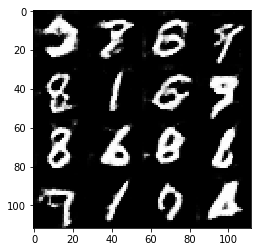

Epoch 0/2... Discriminator Loss: 0.6301... Generator Loss: 1.0844
Epoch 0/2... Discriminator Loss: 0.8492... Generator Loss: 0.7999
Epoch 0/2... Discriminator Loss: 0.6994... Generator Loss: 0.9900
Epoch 0/2... Discriminator Loss: 0.5276... Generator Loss: 1.5512
Epoch 0/2... Discriminator Loss: 0.7525... Generator Loss: 1.0524


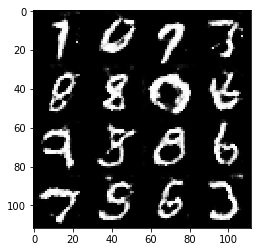

Epoch 0/2... Discriminator Loss: 0.6316... Generator Loss: 1.1667
Epoch 0/2... Discriminator Loss: 1.7973... Generator Loss: 3.0749
Epoch 0/2... Discriminator Loss: 0.7041... Generator Loss: 1.0821
Epoch 0/2... Discriminator Loss: 0.8742... Generator Loss: 1.0483
Epoch 0/2... Discriminator Loss: 0.6637... Generator Loss: 1.0829


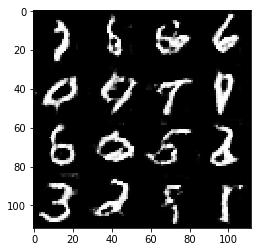

Epoch 0/2... Discriminator Loss: 1.0158... Generator Loss: 0.7779
Epoch 0/2... Discriminator Loss: 1.8081... Generator Loss: 0.2371
Epoch 0/2... Discriminator Loss: 0.5767... Generator Loss: 1.2624
Epoch 1/2... Discriminator Loss: 0.5077... Generator Loss: 2.1872
Epoch 1/2... Discriminator Loss: 1.1128... Generator Loss: 0.6337


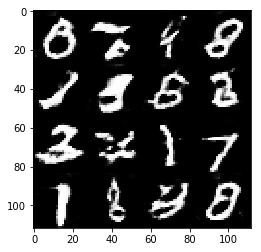

Epoch 1/2... Discriminator Loss: 0.5854... Generator Loss: 2.6524
Epoch 1/2... Discriminator Loss: 1.0297... Generator Loss: 0.6411
Epoch 1/2... Discriminator Loss: 0.8778... Generator Loss: 0.9356
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.4708
Epoch 1/2... Discriminator Loss: 0.8779... Generator Loss: 0.7921


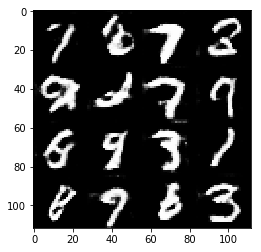

Epoch 1/2... Discriminator Loss: 0.5012... Generator Loss: 1.7707
Epoch 1/2... Discriminator Loss: 0.8549... Generator Loss: 0.9294
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 0.6348
Epoch 1/2... Discriminator Loss: 0.9240... Generator Loss: 0.9016
Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 1.4257


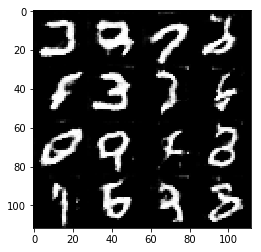

Epoch 1/2... Discriminator Loss: 0.6597... Generator Loss: 1.1262
Epoch 1/2... Discriminator Loss: 0.7662... Generator Loss: 2.0998
Epoch 1/2... Discriminator Loss: 0.7271... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 0.8358... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 0.6531... Generator Loss: 1.1141


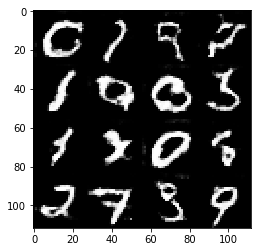

Epoch 1/2... Discriminator Loss: 0.5872... Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 0.4383... Generator Loss: 1.7166
Epoch 1/2... Discriminator Loss: 0.6321... Generator Loss: 1.1152
Epoch 1/2... Discriminator Loss: 1.6951... Generator Loss: 0.3012
Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 0.6542


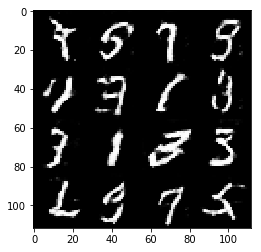

Epoch 1/2... Discriminator Loss: 0.4637... Generator Loss: 1.5863
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 0.7745
Epoch 1/2... Discriminator Loss: 0.7547... Generator Loss: 0.9879
Epoch 1/2... Discriminator Loss: 0.7948... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 0.6976... Generator Loss: 3.3606


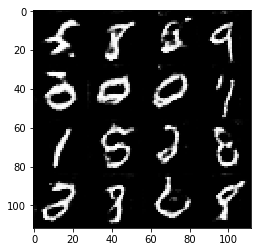

Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 0.6755... Generator Loss: 0.9559
Epoch 1/2... Discriminator Loss: 1.1674... Generator Loss: 0.4548
Epoch 1/2... Discriminator Loss: 0.8283... Generator Loss: 1.0660
Epoch 1/2... Discriminator Loss: 0.4169... Generator Loss: 1.9520


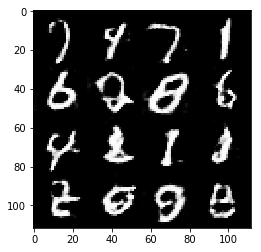

Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 0.8366
Epoch 1/2... Discriminator Loss: 0.4254... Generator Loss: 2.2068
Epoch 1/2... Discriminator Loss: 0.6223... Generator Loss: 1.0085
Epoch 1/2... Discriminator Loss: 0.6091... Generator Loss: 1.5076
Epoch 1/2... Discriminator Loss: 0.5446... Generator Loss: 1.1601


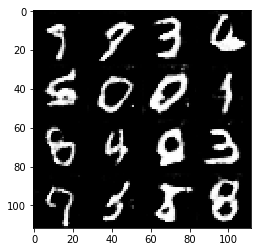

Epoch 1/2... Discriminator Loss: 0.6837... Generator Loss: 1.0960
Epoch 1/2... Discriminator Loss: 0.3874... Generator Loss: 1.7340
Epoch 1/2... Discriminator Loss: 0.7579... Generator Loss: 2.0877
Epoch 1/2... Discriminator Loss: 0.3820... Generator Loss: 1.6757
Epoch 1/2... Discriminator Loss: 1.2074... Generator Loss: 3.7974


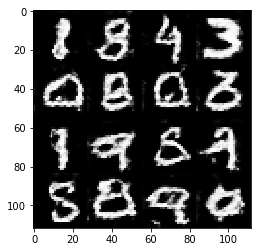

Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 1.7310
Epoch 1/2... Discriminator Loss: 0.8041... Generator Loss: 1.2319
Epoch 1/2... Discriminator Loss: 1.2221... Generator Loss: 0.5061
Epoch 1/2... Discriminator Loss: 0.6107... Generator Loss: 1.2592
Epoch 1/2... Discriminator Loss: 0.6660... Generator Loss: 1.5396


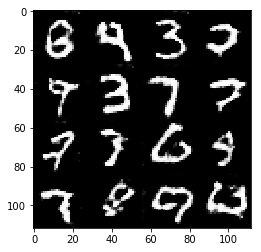

Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 1.2508
Epoch 1/2... Discriminator Loss: 0.8654... Generator Loss: 0.8699
Epoch 1/2... Discriminator Loss: 1.6521... Generator Loss: 0.2773
Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 0.5252
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 0.8076


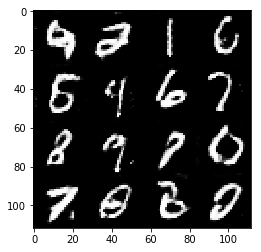

Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 0.6819... Generator Loss: 1.2727
Epoch 1/2... Discriminator Loss: 0.5442... Generator Loss: 1.4886
Epoch 1/2... Discriminator Loss: 0.5607... Generator Loss: 1.1971
Epoch 1/2... Discriminator Loss: 0.5781... Generator Loss: 1.3154


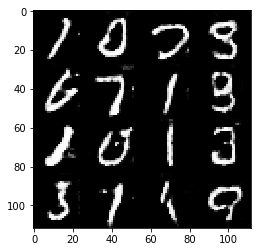

Epoch 1/2... Discriminator Loss: 0.7533... Generator Loss: 1.0397
Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 0.7163
Epoch 1/2... Discriminator Loss: 2.1852... Generator Loss: 0.2134
Epoch 1/2... Discriminator Loss: 0.7911... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 0.6012... Generator Loss: 1.2301


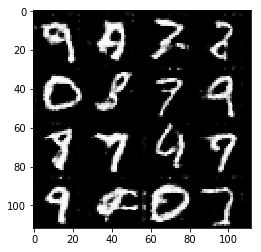

Epoch 1/2... Discriminator Loss: 0.8702... Generator Loss: 0.7821
Epoch 1/2... Discriminator Loss: 1.1176... Generator Loss: 0.5034
Epoch 1/2... Discriminator Loss: 0.4187... Generator Loss: 1.6615
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 0.4610
Epoch 1/2... Discriminator Loss: 2.4237... Generator Loss: 4.2738


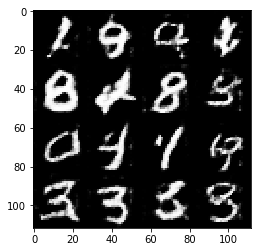

Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 0.6649
Epoch 1/2... Discriminator Loss: 0.8766... Generator Loss: 1.0035
Epoch 1/2... Discriminator Loss: 0.6870... Generator Loss: 1.2193
Epoch 1/2... Discriminator Loss: 0.6058... Generator Loss: 1.2770
Epoch 1/2... Discriminator Loss: 0.7896... Generator Loss: 0.8745


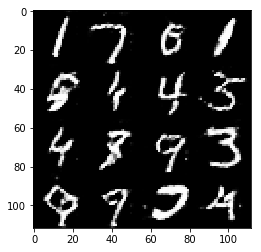

Epoch 1/2... Discriminator Loss: 0.4239... Generator Loss: 1.6700
Epoch 1/2... Discriminator Loss: 0.5848... Generator Loss: 1.3503
Epoch 1/2... Discriminator Loss: 0.5433... Generator Loss: 1.1899
Epoch 1/2... Discriminator Loss: 0.4981... Generator Loss: 1.3551
Epoch 1/2... Discriminator Loss: 1.2398... Generator Loss: 0.5239


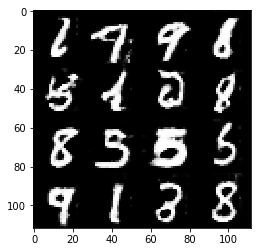

Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.0686
Epoch 1/2... Discriminator Loss: 0.4409... Generator Loss: 1.4850
Epoch 1/2... Discriminator Loss: 0.9272... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 0.4648... Generator Loss: 1.4721
Epoch 1/2... Discriminator Loss: 0.4857... Generator Loss: 1.3569


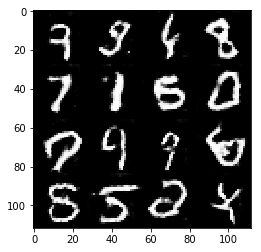

Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 1.1278
Epoch 1/2... Discriminator Loss: 0.3842... Generator Loss: 1.7008
Epoch 1/2... Discriminator Loss: 1.5873... Generator Loss: 0.4169
Epoch 1/2... Discriminator Loss: 0.7929... Generator Loss: 1.4166
Epoch 1/2... Discriminator Loss: 1.0780... Generator Loss: 0.6992


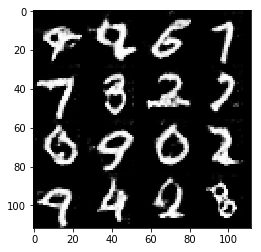

Epoch 1/2... Discriminator Loss: 0.5333... Generator Loss: 1.8519
Epoch 1/2... Discriminator Loss: 0.6758... Generator Loss: 1.8660
Epoch 1/2... Discriminator Loss: 0.4976... Generator Loss: 1.5358
Epoch 1/2... Discriminator Loss: 0.4024... Generator Loss: 1.6843
Epoch 1/2... Discriminator Loss: 1.0183... Generator Loss: 0.7225


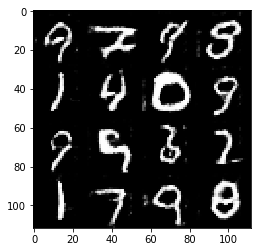

Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 0.7032
Epoch 1/2... Discriminator Loss: 0.5402... Generator Loss: 1.8226
Epoch 1/2... Discriminator Loss: 0.5632... Generator Loss: 1.3453
Epoch 1/2... Discriminator Loss: 0.4675... Generator Loss: 1.3810
Epoch 1/2... Discriminator Loss: 0.6834... Generator Loss: 1.1208


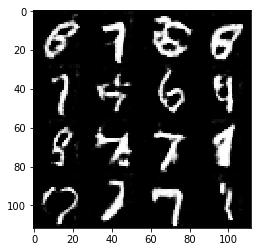

Epoch 1/2... Discriminator Loss: 0.5610... Generator Loss: 1.2740
Epoch 1/2... Discriminator Loss: 0.7136... Generator Loss: 1.0440
Epoch 1/2... Discriminator Loss: 0.7131... Generator Loss: 0.9783
Epoch 1/2... Discriminator Loss: 0.8309... Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 0.9082


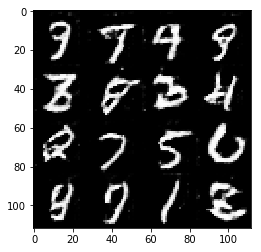

Epoch 1/2... Discriminator Loss: 0.9767... Generator Loss: 2.1428
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 2.1674
Epoch 1/2... Discriminator Loss: 0.6488... Generator Loss: 1.0706
Epoch 1/2... Discriminator Loss: 0.5093... Generator Loss: 1.3503
Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 0.8940


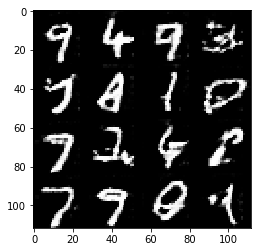

Epoch 1/2... Discriminator Loss: 0.4880... Generator Loss: 1.3941
Epoch 1/2... Discriminator Loss: 0.5929... Generator Loss: 1.2732
Epoch 1/2... Discriminator Loss: 0.5849... Generator Loss: 1.2140
Epoch 1/2... Discriminator Loss: 1.6676... Generator Loss: 0.3006
Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 0.4412


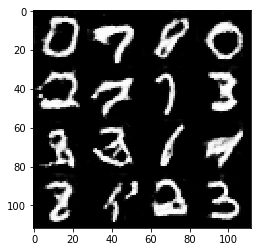

Epoch 1/2... Discriminator Loss: 0.5530... Generator Loss: 1.3895
Epoch 1/2... Discriminator Loss: 0.8713... Generator Loss: 0.7059
Epoch 1/2... Discriminator Loss: 0.4906... Generator Loss: 1.6003
Epoch 1/2... Discriminator Loss: 0.4616... Generator Loss: 1.4116
Epoch 1/2... Discriminator Loss: 0.7142... Generator Loss: 0.8712


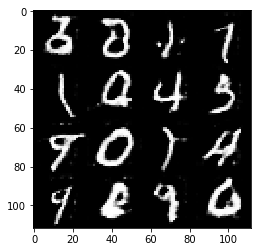

Epoch 1/2... Discriminator Loss: 0.8141... Generator Loss: 0.8221
Epoch 1/2... Discriminator Loss: 0.5162... Generator Loss: 1.2221
Epoch 1/2... Discriminator Loss: 0.3377... Generator Loss: 1.6324
Epoch 1/2... Discriminator Loss: 1.4544... Generator Loss: 0.4469
Epoch 1/2... Discriminator Loss: 0.6765... Generator Loss: 1.0397


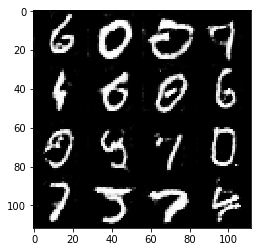

Epoch 1/2... Discriminator Loss: 0.3955... Generator Loss: 1.5638
Epoch 1/2... Discriminator Loss: 0.6790... Generator Loss: 1.0861
Epoch 1/2... Discriminator Loss: 0.4601... Generator Loss: 1.7120
Epoch 1/2... Discriminator Loss: 0.7326... Generator Loss: 0.9848
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 0.7736


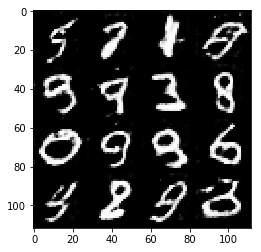

Epoch 1/2... Discriminator Loss: 0.5330... Generator Loss: 1.3800
Epoch 1/2... Discriminator Loss: 0.7797... Generator Loss: 0.9124
Epoch 1/2... Discriminator Loss: 0.7170... Generator Loss: 1.2730
Epoch 1/2... Discriminator Loss: 0.7214... Generator Loss: 0.9765
Epoch 1/2... Discriminator Loss: 0.4341... Generator Loss: 1.8374


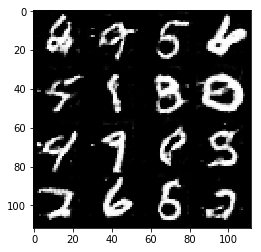

Epoch 1/2... Discriminator Loss: 0.3442... Generator Loss: 2.3681
Epoch 1/2... Discriminator Loss: 0.8036... Generator Loss: 0.8401
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 0.6067
Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 0.5202
Epoch 1/2... Discriminator Loss: 0.6568... Generator Loss: 1.6272


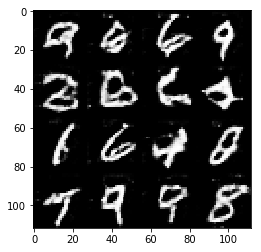

Epoch 1/2... Discriminator Loss: 0.6295... Generator Loss: 2.6054
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 0.6099
Epoch 1/2... Discriminator Loss: 0.7144... Generator Loss: 1.0404
Epoch 1/2... Discriminator Loss: 0.6658... Generator Loss: 1.0741
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 0.7384


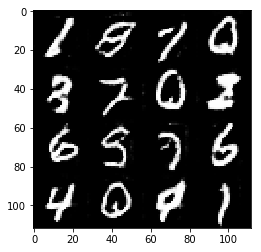

Epoch 1/2... Discriminator Loss: 0.5173... Generator Loss: 2.9185
Epoch 1/2... Discriminator Loss: 0.5264... Generator Loss: 1.1935
Epoch 1/2... Discriminator Loss: 0.4570... Generator Loss: 1.4376
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.4521
Epoch 1/2... Discriminator Loss: 0.5154... Generator Loss: 1.2631


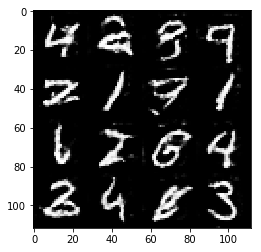

Epoch 1/2... Discriminator Loss: 0.9261... Generator Loss: 0.6837
Epoch 1/2... Discriminator Loss: 0.6699... Generator Loss: 1.0852
Epoch 1/2... Discriminator Loss: 0.7176... Generator Loss: 0.8489
Epoch 1/2... Discriminator Loss: 0.4500... Generator Loss: 1.3058
Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 1.1021


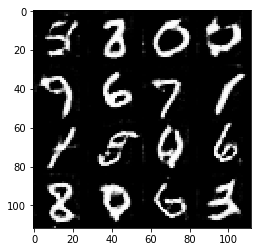

Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.1574... Generator Loss: 0.5230
Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 0.6331... Generator Loss: 1.0409
Epoch 1/2... Discriminator Loss: 0.4621... Generator Loss: 1.4877


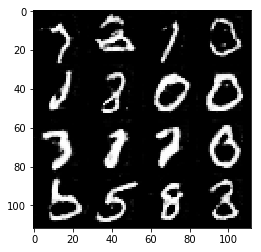

Epoch 1/2... Discriminator Loss: 0.8445... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 1.6822... Generator Loss: 4.7570
Epoch 1/2... Discriminator Loss: 0.4002... Generator Loss: 1.6053
Epoch 1/2... Discriminator Loss: 0.4660... Generator Loss: 1.9023
Epoch 1/2... Discriminator Loss: 0.6011... Generator Loss: 2.0428


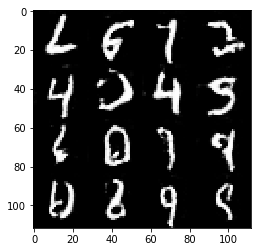

Epoch 1/2... Discriminator Loss: 0.6401... Generator Loss: 1.1158
Epoch 1/2... Discriminator Loss: 0.6045... Generator Loss: 1.0619
Epoch 1/2... Discriminator Loss: 0.4387... Generator Loss: 1.6237
Epoch 1/2... Discriminator Loss: 0.6749... Generator Loss: 0.9584
Epoch 1/2... Discriminator Loss: 0.3906... Generator Loss: 1.7063


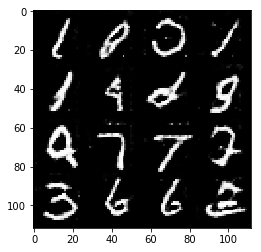

Epoch 1/2... Discriminator Loss: 0.5957... Generator Loss: 1.1463
Epoch 1/2... Discriminator Loss: 0.3682... Generator Loss: 1.6325
Epoch 1/2... Discriminator Loss: 0.5734... Generator Loss: 1.3704
Epoch 1/2... Discriminator Loss: 0.4513... Generator Loss: 1.4840
Epoch 1/2... Discriminator Loss: 1.4370... Generator Loss: 0.4108


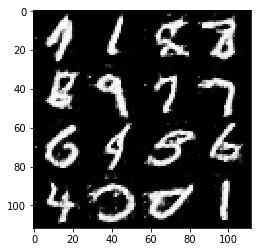

Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 0.2812... Generator Loss: 2.0184
Epoch 1/2... Discriminator Loss: 0.7446... Generator Loss: 2.7770
Epoch 1/2... Discriminator Loss: 0.5287... Generator Loss: 1.2996
Epoch 1/2... Discriminator Loss: 0.6747... Generator Loss: 0.9526


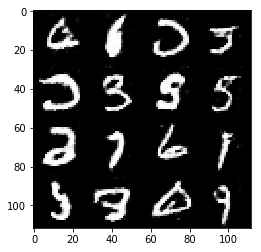

Epoch 1/2... Discriminator Loss: 0.3751... Generator Loss: 1.5677
Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 0.6971
Epoch 1/2... Discriminator Loss: 0.5275... Generator Loss: 1.4259
Epoch 1/2... Discriminator Loss: 0.5861... Generator Loss: 1.6107
Epoch 1/2... Discriminator Loss: 0.6175... Generator Loss: 1.2361


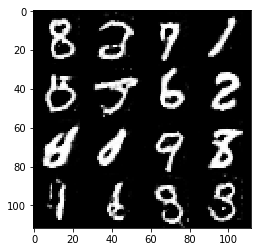

Epoch 1/2... Discriminator Loss: 0.8605... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 0.4324... Generator Loss: 1.5070
Epoch 1/2... Discriminator Loss: 0.6184... Generator Loss: 1.3242
Epoch 1/2... Discriminator Loss: 0.4795... Generator Loss: 1.3148
Epoch 1/2... Discriminator Loss: 0.3782... Generator Loss: 1.7270


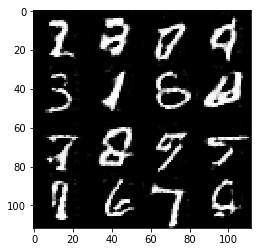

Epoch 1/2... Discriminator Loss: 0.2824... Generator Loss: 1.8757


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 1.9291... Generator Loss: 0.2114
Epoch 0/1... Discriminator Loss: 2.0078... Generator Loss: 0.1940
Epoch 0/1... Discriminator Loss: 0.6918... Generator Loss: 0.9674
Epoch 0/1... Discriminator Loss: 0.4060... Generator Loss: 1.4011


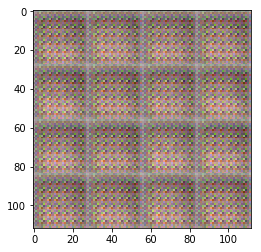

Epoch 0/1... Discriminator Loss: 0.3465... Generator Loss: 2.0624
Epoch 0/1... Discriminator Loss: 0.8766... Generator Loss: 3.2652
Epoch 0/1... Discriminator Loss: 2.9362... Generator Loss: 0.1116
Epoch 0/1... Discriminator Loss: 0.3186... Generator Loss: 1.9683
Epoch 0/1... Discriminator Loss: 0.8408... Generator Loss: 1.1626


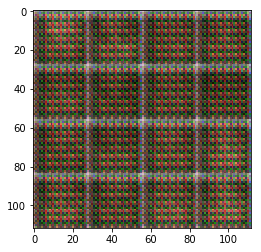

Epoch 0/1... Discriminator Loss: 0.7465... Generator Loss: 1.3437
Epoch 0/1... Discriminator Loss: 0.9167... Generator Loss: 1.2720
Epoch 0/1... Discriminator Loss: 0.3931... Generator Loss: 1.7837
Epoch 0/1... Discriminator Loss: 1.3750... Generator Loss: 0.4220
Epoch 0/1... Discriminator Loss: 1.3188... Generator Loss: 1.0811


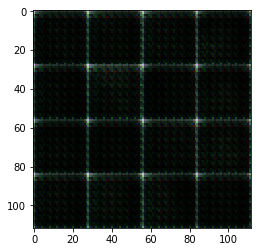

Epoch 0/1... Discriminator Loss: 0.9853... Generator Loss: 0.8441
Epoch 0/1... Discriminator Loss: 0.7704... Generator Loss: 1.5262
Epoch 0/1... Discriminator Loss: 1.3801... Generator Loss: 0.6171
Epoch 0/1... Discriminator Loss: 1.3752... Generator Loss: 1.5197
Epoch 0/1... Discriminator Loss: 0.8104... Generator Loss: 1.9101


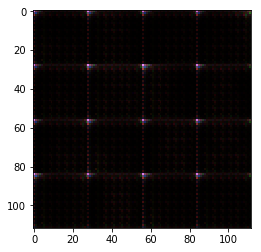

Epoch 0/1... Discriminator Loss: 0.8628... Generator Loss: 1.2030
Epoch 0/1... Discriminator Loss: 1.0960... Generator Loss: 0.7679
Epoch 0/1... Discriminator Loss: 0.7933... Generator Loss: 2.6156
Epoch 0/1... Discriminator Loss: 1.2839... Generator Loss: 0.7218
Epoch 0/1... Discriminator Loss: 0.9035... Generator Loss: 1.0003


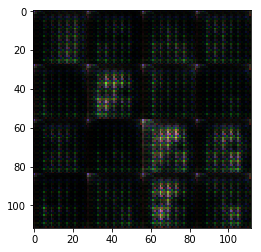

Epoch 0/1... Discriminator Loss: 0.8845... Generator Loss: 1.8864
Epoch 0/1... Discriminator Loss: 1.3227... Generator Loss: 0.4582
Epoch 0/1... Discriminator Loss: 1.0410... Generator Loss: 1.0468
Epoch 0/1... Discriminator Loss: 1.1041... Generator Loss: 0.6478
Epoch 0/1... Discriminator Loss: 0.9622... Generator Loss: 1.3754


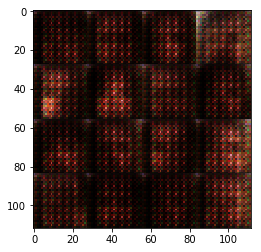

Epoch 0/1... Discriminator Loss: 1.0200... Generator Loss: 0.8013
Epoch 0/1... Discriminator Loss: 0.9621... Generator Loss: 0.9655
Epoch 0/1... Discriminator Loss: 1.1886... Generator Loss: 3.0705
Epoch 0/1... Discriminator Loss: 0.7673... Generator Loss: 2.1017
Epoch 0/1... Discriminator Loss: 1.0055... Generator Loss: 1.2377


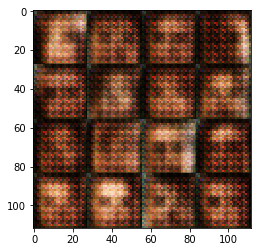

Epoch 0/1... Discriminator Loss: 1.2225... Generator Loss: 1.6484
Epoch 0/1... Discriminator Loss: 0.8126... Generator Loss: 1.7294
Epoch 0/1... Discriminator Loss: 1.6287... Generator Loss: 0.3696
Epoch 0/1... Discriminator Loss: 1.0560... Generator Loss: 1.0236
Epoch 0/1... Discriminator Loss: 1.5546... Generator Loss: 0.4588


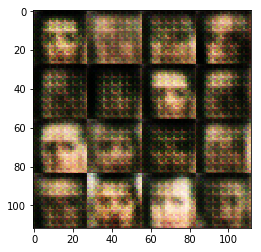

Epoch 0/1... Discriminator Loss: 1.1434... Generator Loss: 1.6640
Epoch 0/1... Discriminator Loss: 1.5303... Generator Loss: 0.4423
Epoch 0/1... Discriminator Loss: 1.3906... Generator Loss: 0.7895
Epoch 0/1... Discriminator Loss: 1.0931... Generator Loss: 1.0054
Epoch 0/1... Discriminator Loss: 1.2172... Generator Loss: 0.8448


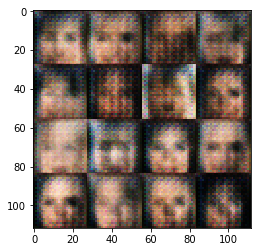

Epoch 0/1... Discriminator Loss: 1.2036... Generator Loss: 1.0878
Epoch 0/1... Discriminator Loss: 1.2580... Generator Loss: 0.6254
Epoch 0/1... Discriminator Loss: 1.3936... Generator Loss: 0.7564
Epoch 0/1... Discriminator Loss: 1.6256... Generator Loss: 0.4511
Epoch 0/1... Discriminator Loss: 1.2683... Generator Loss: 1.0493


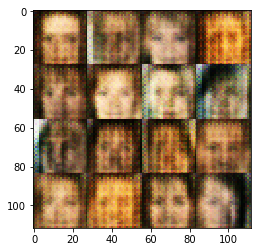

Epoch 0/1... Discriminator Loss: 1.4114... Generator Loss: 0.5543
Epoch 0/1... Discriminator Loss: 1.2028... Generator Loss: 0.6826
Epoch 0/1... Discriminator Loss: 1.1938... Generator Loss: 0.6772
Epoch 0/1... Discriminator Loss: 1.4026... Generator Loss: 0.7998
Epoch 0/1... Discriminator Loss: 1.6708... Generator Loss: 0.4713


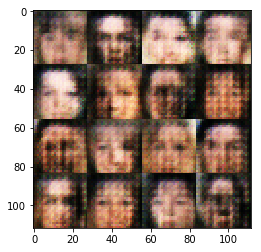

Epoch 0/1... Discriminator Loss: 1.4498... Generator Loss: 0.8661
Epoch 0/1... Discriminator Loss: 1.2032... Generator Loss: 0.6255
Epoch 0/1... Discriminator Loss: 0.9298... Generator Loss: 1.0789
Epoch 0/1... Discriminator Loss: 1.2529... Generator Loss: 0.6653
Epoch 0/1... Discriminator Loss: 1.2377... Generator Loss: 0.8153


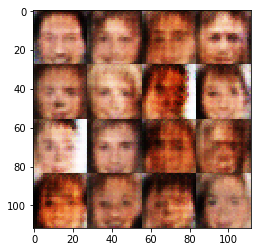

Epoch 0/1... Discriminator Loss: 1.2910... Generator Loss: 0.6939
Epoch 0/1... Discriminator Loss: 1.1978... Generator Loss: 0.7311
Epoch 0/1... Discriminator Loss: 1.3490... Generator Loss: 0.5981
Epoch 0/1... Discriminator Loss: 0.9849... Generator Loss: 0.8752
Epoch 0/1... Discriminator Loss: 0.9275... Generator Loss: 0.9088


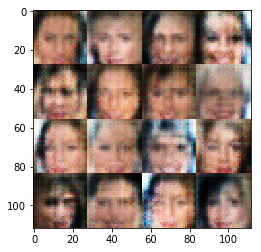

Epoch 0/1... Discriminator Loss: 1.1787... Generator Loss: 0.8355
Epoch 0/1... Discriminator Loss: 1.3602... Generator Loss: 0.6596
Epoch 0/1... Discriminator Loss: 1.3636... Generator Loss: 0.5196
Epoch 0/1... Discriminator Loss: 1.6087... Generator Loss: 0.3735
Epoch 0/1... Discriminator Loss: 1.4704... Generator Loss: 0.6026


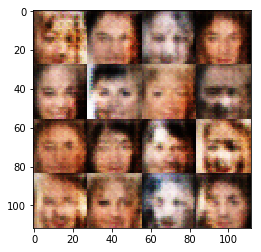

Epoch 0/1... Discriminator Loss: 1.5043... Generator Loss: 0.8429
Epoch 0/1... Discriminator Loss: 1.0103... Generator Loss: 0.9519
Epoch 0/1... Discriminator Loss: 1.1013... Generator Loss: 0.7415
Epoch 0/1... Discriminator Loss: 1.3327... Generator Loss: 0.7381
Epoch 0/1... Discriminator Loss: 1.1083... Generator Loss: 0.7877


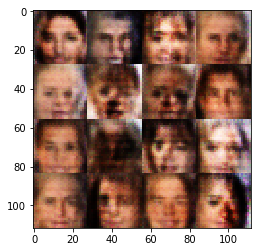

Epoch 0/1... Discriminator Loss: 1.2547... Generator Loss: 0.7222
Epoch 0/1... Discriminator Loss: 1.2215... Generator Loss: 0.6583
Epoch 0/1... Discriminator Loss: 1.4160... Generator Loss: 0.7567
Epoch 0/1... Discriminator Loss: 1.3054... Generator Loss: 0.7817
Epoch 0/1... Discriminator Loss: 1.1429... Generator Loss: 0.8604


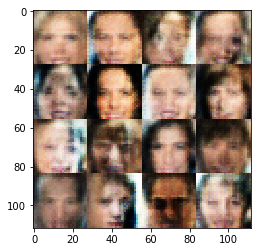

Epoch 0/1... Discriminator Loss: 1.1907... Generator Loss: 0.8176
Epoch 0/1... Discriminator Loss: 1.2662... Generator Loss: 0.7274
Epoch 0/1... Discriminator Loss: 1.2919... Generator Loss: 0.5913
Epoch 0/1... Discriminator Loss: 1.2469... Generator Loss: 0.6083
Epoch 0/1... Discriminator Loss: 1.3402... Generator Loss: 0.9148


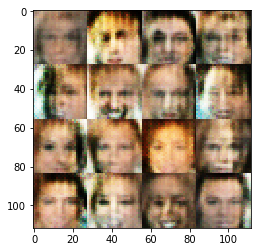

Epoch 0/1... Discriminator Loss: 1.1016... Generator Loss: 0.9804
Epoch 0/1... Discriminator Loss: 1.3489... Generator Loss: 0.8427
Epoch 0/1... Discriminator Loss: 1.3803... Generator Loss: 0.8449
Epoch 0/1... Discriminator Loss: 1.3100... Generator Loss: 0.7327
Epoch 0/1... Discriminator Loss: 1.2484... Generator Loss: 1.2192


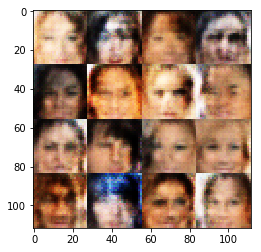

Epoch 0/1... Discriminator Loss: 1.2308... Generator Loss: 0.7366
Epoch 0/1... Discriminator Loss: 1.4404... Generator Loss: 0.5496
Epoch 0/1... Discriminator Loss: 1.2634... Generator Loss: 0.6093
Epoch 0/1... Discriminator Loss: 1.2483... Generator Loss: 0.7717
Epoch 0/1... Discriminator Loss: 1.2725... Generator Loss: 0.5457


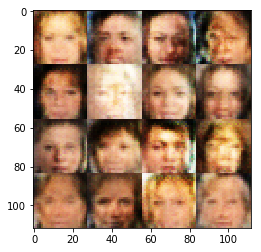

Epoch 0/1... Discriminator Loss: 1.0225... Generator Loss: 1.0825
Epoch 0/1... Discriminator Loss: 1.2790... Generator Loss: 0.5899
Epoch 0/1... Discriminator Loss: 1.3437... Generator Loss: 0.9019
Epoch 0/1... Discriminator Loss: 1.5074... Generator Loss: 0.5068
Epoch 0/1... Discriminator Loss: 1.3386... Generator Loss: 0.6688


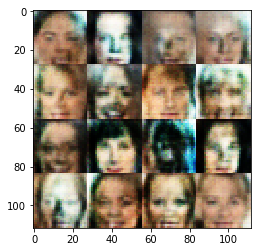

Epoch 0/1... Discriminator Loss: 1.3533... Generator Loss: 0.5436
Epoch 0/1... Discriminator Loss: 1.1194... Generator Loss: 0.9710
Epoch 0/1... Discriminator Loss: 1.2150... Generator Loss: 0.7514
Epoch 0/1... Discriminator Loss: 1.0170... Generator Loss: 0.9230
Epoch 0/1... Discriminator Loss: 1.1948... Generator Loss: 0.9748


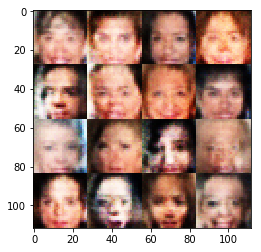

Epoch 0/1... Discriminator Loss: 1.3335... Generator Loss: 0.8250
Epoch 0/1... Discriminator Loss: 1.2884... Generator Loss: 0.5877
Epoch 0/1... Discriminator Loss: 1.0661... Generator Loss: 0.7490
Epoch 0/1... Discriminator Loss: 1.2860... Generator Loss: 0.5246
Epoch 0/1... Discriminator Loss: 1.3704... Generator Loss: 0.5503


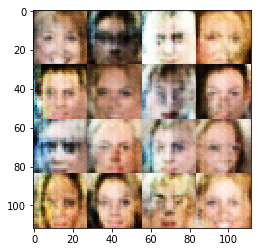

Epoch 0/1... Discriminator Loss: 1.5831... Generator Loss: 0.3435
Epoch 0/1... Discriminator Loss: 1.3070... Generator Loss: 0.7414
Epoch 0/1... Discriminator Loss: 1.4138... Generator Loss: 0.6726
Epoch 0/1... Discriminator Loss: 1.0493... Generator Loss: 1.0457
Epoch 0/1... Discriminator Loss: 1.1064... Generator Loss: 0.9674


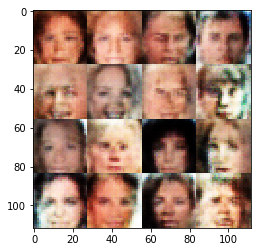

Epoch 0/1... Discriminator Loss: 1.1669... Generator Loss: 0.7597
Epoch 0/1... Discriminator Loss: 1.1045... Generator Loss: 0.7339
Epoch 0/1... Discriminator Loss: 1.3168... Generator Loss: 0.5147
Epoch 0/1... Discriminator Loss: 1.1806... Generator Loss: 0.6119
Epoch 0/1... Discriminator Loss: 1.2662... Generator Loss: 0.7009


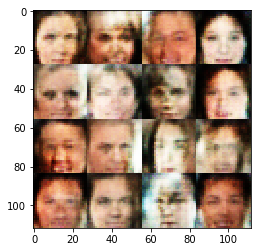

Epoch 0/1... Discriminator Loss: 1.2209... Generator Loss: 0.7376
Epoch 0/1... Discriminator Loss: 1.2730... Generator Loss: 0.5532
Epoch 0/1... Discriminator Loss: 1.4149... Generator Loss: 0.4499
Epoch 0/1... Discriminator Loss: 1.1193... Generator Loss: 0.9619
Epoch 0/1... Discriminator Loss: 1.3624... Generator Loss: 0.6670


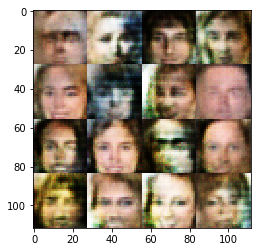

Epoch 0/1... Discriminator Loss: 1.4166... Generator Loss: 0.4804
Epoch 0/1... Discriminator Loss: 1.0843... Generator Loss: 0.7904
Epoch 0/1... Discriminator Loss: 1.1888... Generator Loss: 0.8118
Epoch 0/1... Discriminator Loss: 1.4255... Generator Loss: 0.4689
Epoch 0/1... Discriminator Loss: 1.2249... Generator Loss: 0.7322


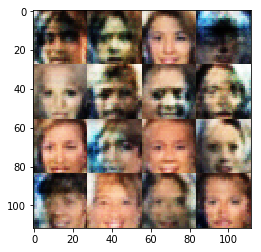

Epoch 0/1... Discriminator Loss: 1.5038... Generator Loss: 0.5032
Epoch 0/1... Discriminator Loss: 1.1156... Generator Loss: 0.9331
Epoch 0/1... Discriminator Loss: 1.4112... Generator Loss: 0.4505
Epoch 0/1... Discriminator Loss: 1.6137... Generator Loss: 0.3778
Epoch 0/1... Discriminator Loss: 1.6326... Generator Loss: 0.3697


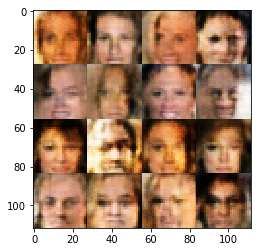

Epoch 0/1... Discriminator Loss: 1.1395... Generator Loss: 0.9492
Epoch 0/1... Discriminator Loss: 1.2869... Generator Loss: 0.9040
Epoch 0/1... Discriminator Loss: 1.1512... Generator Loss: 0.6892
Epoch 0/1... Discriminator Loss: 1.2708... Generator Loss: 0.6416
Epoch 0/1... Discriminator Loss: 1.4549... Generator Loss: 0.6609


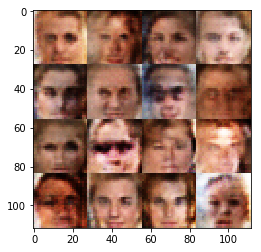

Epoch 0/1... Discriminator Loss: 1.4383... Generator Loss: 0.4017
Epoch 0/1... Discriminator Loss: 1.2350... Generator Loss: 0.6032
Epoch 0/1... Discriminator Loss: 1.3842... Generator Loss: 0.6148
Epoch 0/1... Discriminator Loss: 1.2006... Generator Loss: 0.7453
Epoch 0/1... Discriminator Loss: 1.2175... Generator Loss: 0.7605


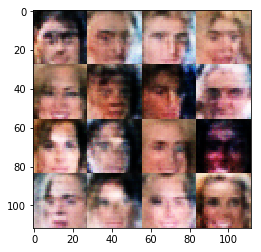

Epoch 0/1... Discriminator Loss: 1.1383... Generator Loss: 0.7474
Epoch 0/1... Discriminator Loss: 1.2571... Generator Loss: 0.8673
Epoch 0/1... Discriminator Loss: 1.2643... Generator Loss: 0.8079
Epoch 0/1... Discriminator Loss: 1.0252... Generator Loss: 0.7936
Epoch 0/1... Discriminator Loss: 1.2252... Generator Loss: 0.6185


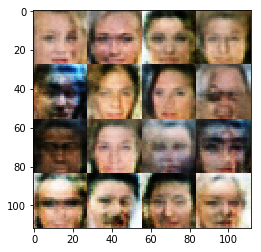

Epoch 0/1... Discriminator Loss: 1.2327... Generator Loss: 0.5272
Epoch 0/1... Discriminator Loss: 1.3635... Generator Loss: 0.5622
Epoch 0/1... Discriminator Loss: 1.2184... Generator Loss: 0.5502
Epoch 0/1... Discriminator Loss: 1.6138... Generator Loss: 0.3485
Epoch 0/1... Discriminator Loss: 1.3101... Generator Loss: 0.5820


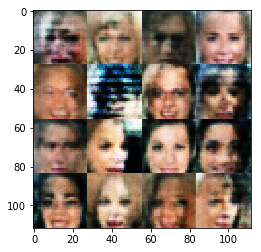

Epoch 0/1... Discriminator Loss: 0.9064... Generator Loss: 0.9479
Epoch 0/1... Discriminator Loss: 1.2371... Generator Loss: 0.7135
Epoch 0/1... Discriminator Loss: 1.1039... Generator Loss: 0.9614
Epoch 0/1... Discriminator Loss: 1.2780... Generator Loss: 0.6481
Epoch 0/1... Discriminator Loss: 1.2492... Generator Loss: 0.6180


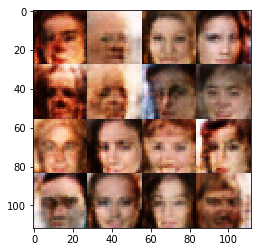

Epoch 0/1... Discriminator Loss: 1.2384... Generator Loss: 0.5809
Epoch 0/1... Discriminator Loss: 1.3951... Generator Loss: 0.5286
Epoch 0/1... Discriminator Loss: 1.0497... Generator Loss: 1.1159
Epoch 0/1... Discriminator Loss: 1.0491... Generator Loss: 1.0109
Epoch 0/1... Discriminator Loss: 1.4477... Generator Loss: 0.5442


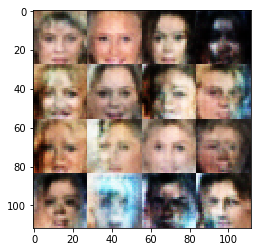

Epoch 0/1... Discriminator Loss: 1.3475... Generator Loss: 0.6005
Epoch 0/1... Discriminator Loss: 1.1495... Generator Loss: 0.6703
Epoch 0/1... Discriminator Loss: 1.1060... Generator Loss: 0.7440
Epoch 0/1... Discriminator Loss: 1.2363... Generator Loss: 0.6785
Epoch 0/1... Discriminator Loss: 1.4752... Generator Loss: 0.5086


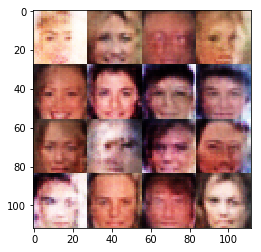

Epoch 0/1... Discriminator Loss: 1.3163... Generator Loss: 0.6427
Epoch 0/1... Discriminator Loss: 1.1780... Generator Loss: 0.8218
Epoch 0/1... Discriminator Loss: 1.2686... Generator Loss: 0.6796
Epoch 0/1... Discriminator Loss: 1.1624... Generator Loss: 0.6915
Epoch 0/1... Discriminator Loss: 1.2740... Generator Loss: 0.5581


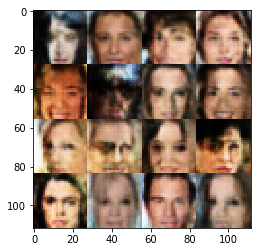

Epoch 0/1... Discriminator Loss: 1.2152... Generator Loss: 1.1196
Epoch 0/1... Discriminator Loss: 1.1190... Generator Loss: 0.7602
Epoch 0/1... Discriminator Loss: 1.4726... Generator Loss: 0.4519
Epoch 0/1... Discriminator Loss: 1.2508... Generator Loss: 0.5666
Epoch 0/1... Discriminator Loss: 1.3375... Generator Loss: 0.4365


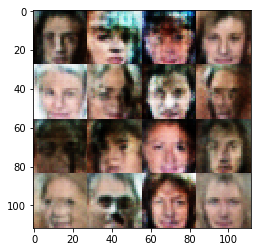

Epoch 0/1... Discriminator Loss: 1.2400... Generator Loss: 0.6097
Epoch 0/1... Discriminator Loss: 1.1259... Generator Loss: 0.6812
Epoch 0/1... Discriminator Loss: 1.2856... Generator Loss: 0.8164
Epoch 0/1... Discriminator Loss: 1.3071... Generator Loss: 0.8100
Epoch 0/1... Discriminator Loss: 1.0199... Generator Loss: 0.9561


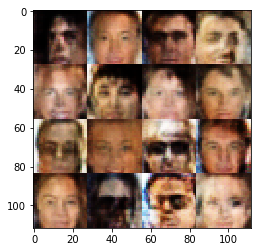

Epoch 0/1... Discriminator Loss: 1.1280... Generator Loss: 0.6259
Epoch 0/1... Discriminator Loss: 0.9639... Generator Loss: 1.1041
Epoch 0/1... Discriminator Loss: 1.3554... Generator Loss: 0.6639
Epoch 0/1... Discriminator Loss: 0.9229... Generator Loss: 1.0433
Epoch 0/1... Discriminator Loss: 1.3163... Generator Loss: 0.5309


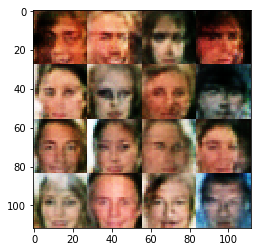

Epoch 0/1... Discriminator Loss: 1.2531... Generator Loss: 0.5935
Epoch 0/1... Discriminator Loss: 0.8890... Generator Loss: 1.0677
Epoch 0/1... Discriminator Loss: 1.4148... Generator Loss: 0.5464
Epoch 0/1... Discriminator Loss: 1.2612... Generator Loss: 0.5316
Epoch 0/1... Discriminator Loss: 1.0856... Generator Loss: 0.7523


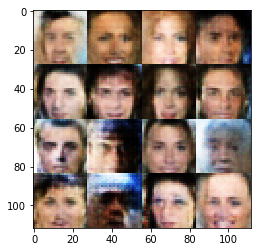

Epoch 0/1... Discriminator Loss: 1.1949... Generator Loss: 0.9206
Epoch 0/1... Discriminator Loss: 1.2970... Generator Loss: 0.8011
Epoch 0/1... Discriminator Loss: 1.1249... Generator Loss: 0.8387
Epoch 0/1... Discriminator Loss: 1.6515... Generator Loss: 0.4796
Epoch 0/1... Discriminator Loss: 1.3296... Generator Loss: 0.7293


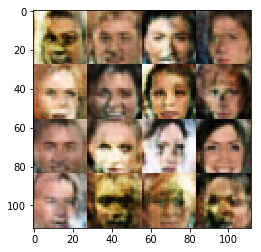

Epoch 0/1... Discriminator Loss: 1.2678... Generator Loss: 0.7186
Epoch 0/1... Discriminator Loss: 1.4850... Generator Loss: 0.5080
Epoch 0/1... Discriminator Loss: 1.0503... Generator Loss: 0.7150
Epoch 0/1... Discriminator Loss: 1.2579... Generator Loss: 0.8464
Epoch 0/1... Discriminator Loss: 1.5730... Generator Loss: 0.5249


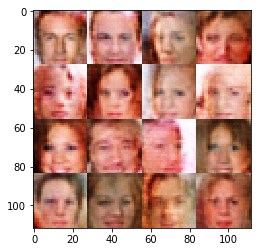

Epoch 0/1... Discriminator Loss: 1.0336... Generator Loss: 1.0855
Epoch 0/1... Discriminator Loss: 1.3734... Generator Loss: 1.0195
Epoch 0/1... Discriminator Loss: 1.2159... Generator Loss: 0.8484
Epoch 0/1... Discriminator Loss: 1.1338... Generator Loss: 0.7069
Epoch 0/1... Discriminator Loss: 1.4301... Generator Loss: 0.6281


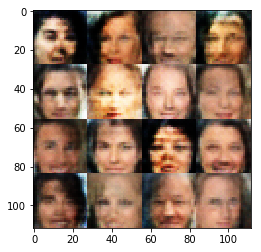

Epoch 0/1... Discriminator Loss: 1.3694... Generator Loss: 0.4839
Epoch 0/1... Discriminator Loss: 1.1271... Generator Loss: 0.9185
Epoch 0/1... Discriminator Loss: 1.4324... Generator Loss: 0.5129
Epoch 0/1... Discriminator Loss: 1.0420... Generator Loss: 0.7972
Epoch 0/1... Discriminator Loss: 1.2390... Generator Loss: 0.5561


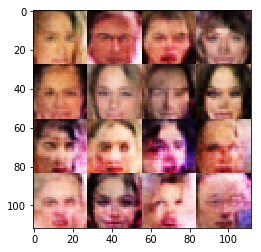

Epoch 0/1... Discriminator Loss: 1.4506... Generator Loss: 0.4308
Epoch 0/1... Discriminator Loss: 1.2054... Generator Loss: 0.8027
Epoch 0/1... Discriminator Loss: 1.4272... Generator Loss: 0.5984
Epoch 0/1... Discriminator Loss: 1.2966... Generator Loss: 0.7214
Epoch 0/1... Discriminator Loss: 1.2700... Generator Loss: 0.5444


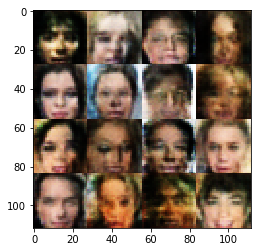

Epoch 0/1... Discriminator Loss: 1.3936... Generator Loss: 0.5228
Epoch 0/1... Discriminator Loss: 1.0793... Generator Loss: 0.7419
Epoch 0/1... Discriminator Loss: 1.3778... Generator Loss: 0.4783
Epoch 0/1... Discriminator Loss: 1.0347... Generator Loss: 0.7401
Epoch 0/1... Discriminator Loss: 1.2054... Generator Loss: 0.8127


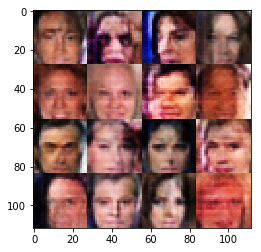

Epoch 0/1... Discriminator Loss: 1.3120... Generator Loss: 0.4971
Epoch 0/1... Discriminator Loss: 1.2283... Generator Loss: 0.8158
Epoch 0/1... Discriminator Loss: 1.1503... Generator Loss: 1.2541
Epoch 0/1... Discriminator Loss: 1.0523... Generator Loss: 0.6800
Epoch 0/1... Discriminator Loss: 0.9562... Generator Loss: 0.8797


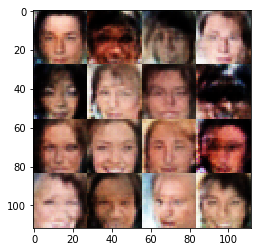

Epoch 0/1... Discriminator Loss: 1.3613... Generator Loss: 0.5536
Epoch 0/1... Discriminator Loss: 1.5310... Generator Loss: 0.5798
Epoch 0/1... Discriminator Loss: 1.2710... Generator Loss: 0.5464
Epoch 0/1... Discriminator Loss: 1.6718... Generator Loss: 0.3131
Epoch 0/1... Discriminator Loss: 1.1741... Generator Loss: 0.7609


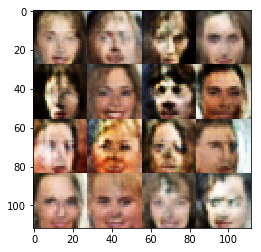

Epoch 0/1... Discriminator Loss: 1.3566... Generator Loss: 0.4845
Epoch 0/1... Discriminator Loss: 1.0204... Generator Loss: 0.8771
Epoch 0/1... Discriminator Loss: 1.1459... Generator Loss: 0.7066
Epoch 0/1... Discriminator Loss: 1.0648... Generator Loss: 0.7820
Epoch 0/1... Discriminator Loss: 1.1621... Generator Loss: 0.8167


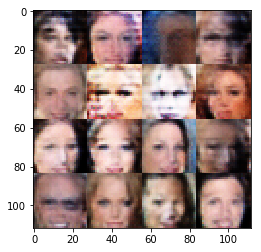

Epoch 0/1... Discriminator Loss: 0.8458... Generator Loss: 0.9491
Epoch 0/1... Discriminator Loss: 1.2175... Generator Loss: 0.6075
Epoch 0/1... Discriminator Loss: 1.1603... Generator Loss: 0.7681
Epoch 0/1... Discriminator Loss: 1.5084... Generator Loss: 0.4236
Epoch 0/1... Discriminator Loss: 1.5701... Generator Loss: 0.3760


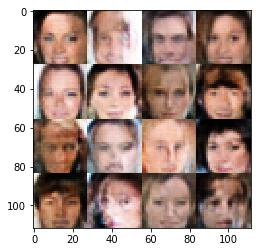

Epoch 0/1... Discriminator Loss: 1.0240... Generator Loss: 0.7712
Epoch 0/1... Discriminator Loss: 1.3080... Generator Loss: 0.5913
Epoch 0/1... Discriminator Loss: 1.2580... Generator Loss: 0.7258
Epoch 0/1... Discriminator Loss: 1.1871... Generator Loss: 0.6124
Epoch 0/1... Discriminator Loss: 1.3092... Generator Loss: 0.5876


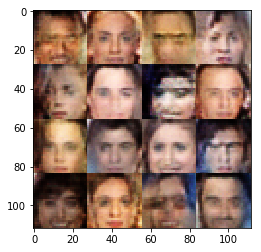

Epoch 0/1... Discriminator Loss: 1.2228... Generator Loss: 0.6497
Epoch 0/1... Discriminator Loss: 0.9769... Generator Loss: 1.2156
Epoch 0/1... Discriminator Loss: 1.4477... Generator Loss: 0.3903
Epoch 0/1... Discriminator Loss: 1.0651... Generator Loss: 0.6349
Epoch 0/1... Discriminator Loss: 1.2115... Generator Loss: 0.7570


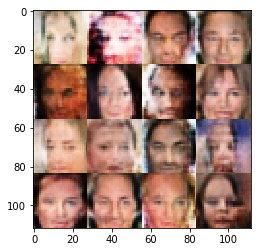

Epoch 0/1... Discriminator Loss: 1.2610... Generator Loss: 0.6748
Epoch 0/1... Discriminator Loss: 1.6390... Generator Loss: 0.3040
Epoch 0/1... Discriminator Loss: 1.1072... Generator Loss: 0.7806
Epoch 0/1... Discriminator Loss: 1.0225... Generator Loss: 0.9036
Epoch 0/1... Discriminator Loss: 1.2205... Generator Loss: 1.0088


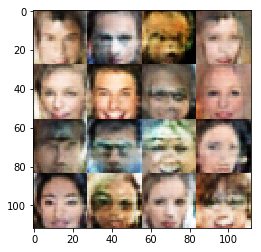

Epoch 0/1... Discriminator Loss: 1.3312... Generator Loss: 0.5692
Epoch 0/1... Discriminator Loss: 1.1449... Generator Loss: 0.6811
Epoch 0/1... Discriminator Loss: 1.2333... Generator Loss: 0.6840
Epoch 0/1... Discriminator Loss: 1.0774... Generator Loss: 0.7827
Epoch 0/1... Discriminator Loss: 1.1867... Generator Loss: 0.6150


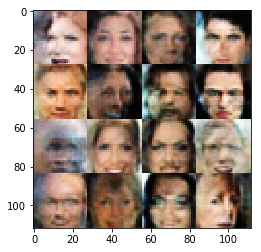

Epoch 0/1... Discriminator Loss: 1.3450... Generator Loss: 0.5156
Epoch 0/1... Discriminator Loss: 1.2616... Generator Loss: 1.9330
Epoch 0/1... Discriminator Loss: 1.3610... Generator Loss: 0.7798
Epoch 0/1... Discriminator Loss: 1.4491... Generator Loss: 0.4274
Epoch 0/1... Discriminator Loss: 1.0646... Generator Loss: 0.7860


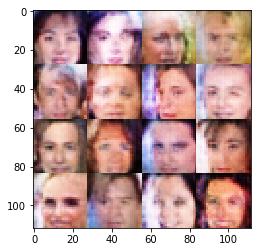

Epoch 0/1... Discriminator Loss: 1.3399... Generator Loss: 0.5269
Epoch 0/1... Discriminator Loss: 1.1346... Generator Loss: 0.6926
Epoch 0/1... Discriminator Loss: 1.0008... Generator Loss: 0.8203
Epoch 0/1... Discriminator Loss: 1.4081... Generator Loss: 0.5647
Epoch 0/1... Discriminator Loss: 1.2320... Generator Loss: 0.6532


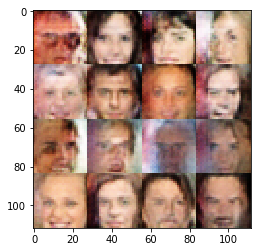

Epoch 0/1... Discriminator Loss: 1.1977... Generator Loss: 0.6806
Epoch 0/1... Discriminator Loss: 1.1102... Generator Loss: 0.8840
Epoch 0/1... Discriminator Loss: 1.2311... Generator Loss: 0.5441
Epoch 0/1... Discriminator Loss: 1.7901... Generator Loss: 0.2513
Epoch 0/1... Discriminator Loss: 1.2213... Generator Loss: 0.8138


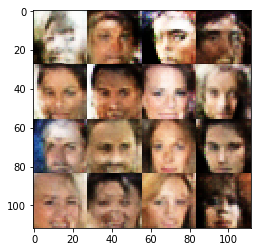

Epoch 0/1... Discriminator Loss: 1.2221... Generator Loss: 0.5750
Epoch 0/1... Discriminator Loss: 1.0361... Generator Loss: 0.8450
Epoch 0/1... Discriminator Loss: 1.4697... Generator Loss: 0.5366
Epoch 0/1... Discriminator Loss: 1.0217... Generator Loss: 0.9191
Epoch 0/1... Discriminator Loss: 1.4304... Generator Loss: 0.4599


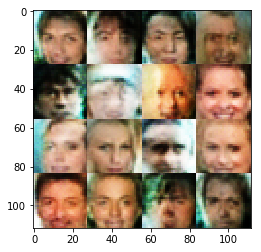

Epoch 0/1... Discriminator Loss: 1.4864... Generator Loss: 0.5291
Epoch 0/1... Discriminator Loss: 1.3461... Generator Loss: 0.6568
Epoch 0/1... Discriminator Loss: 1.0479... Generator Loss: 0.8702
Epoch 0/1... Discriminator Loss: 0.8625... Generator Loss: 1.0678
Epoch 0/1... Discriminator Loss: 1.4052... Generator Loss: 0.6836


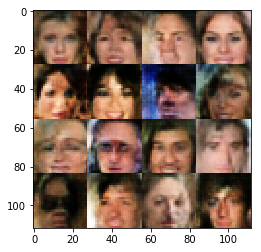

Epoch 0/1... Discriminator Loss: 1.2830... Generator Loss: 0.6633
Epoch 0/1... Discriminator Loss: 1.1969... Generator Loss: 0.5980
Epoch 0/1... Discriminator Loss: 1.2831... Generator Loss: 0.5933
Epoch 0/1... Discriminator Loss: 1.1014... Generator Loss: 0.8176
Epoch 0/1... Discriminator Loss: 1.1887... Generator Loss: 1.2415


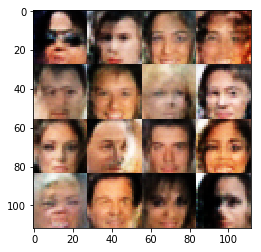

Epoch 0/1... Discriminator Loss: 0.9005... Generator Loss: 0.9892
Epoch 0/1... Discriminator Loss: 1.0287... Generator Loss: 0.9503
Epoch 0/1... Discriminator Loss: 1.1350... Generator Loss: 0.6291
Epoch 0/1... Discriminator Loss: 1.1484... Generator Loss: 0.7249
Epoch 0/1... Discriminator Loss: 0.8680... Generator Loss: 0.9879


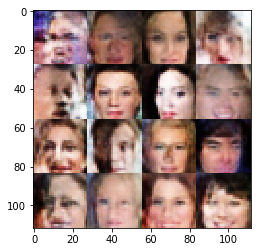

Epoch 0/1... Discriminator Loss: 1.1341... Generator Loss: 0.8595
Epoch 0/1... Discriminator Loss: 1.2145... Generator Loss: 0.5510
Epoch 0/1... Discriminator Loss: 1.3822... Generator Loss: 0.4339
Epoch 0/1... Discriminator Loss: 1.1822... Generator Loss: 0.6204
Epoch 0/1... Discriminator Loss: 1.1945... Generator Loss: 0.7920


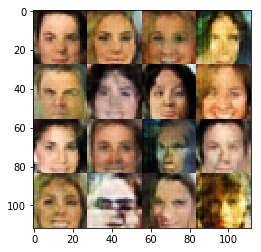

Epoch 0/1... Discriminator Loss: 0.8132... Generator Loss: 1.0730
Epoch 0/1... Discriminator Loss: 1.0162... Generator Loss: 0.9794
Epoch 0/1... Discriminator Loss: 1.3534... Generator Loss: 0.4208
Epoch 0/1... Discriminator Loss: 0.9938... Generator Loss: 1.1568
Epoch 0/1... Discriminator Loss: 1.3186... Generator Loss: 0.5801


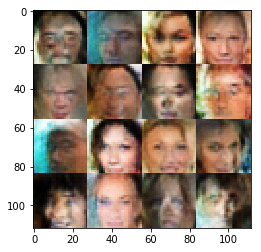

Epoch 0/1... Discriminator Loss: 1.3162... Generator Loss: 0.5970
Epoch 0/1... Discriminator Loss: 1.7782... Generator Loss: 0.2631
Epoch 0/1... Discriminator Loss: 1.1755... Generator Loss: 0.6053
Epoch 0/1... Discriminator Loss: 1.0479... Generator Loss: 0.8393
Epoch 0/1... Discriminator Loss: 1.3353... Generator Loss: 0.6646


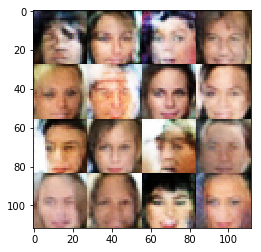

Epoch 0/1... Discriminator Loss: 1.0677... Generator Loss: 0.8028


KeyboardInterrupt: 

In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.